In [1]:
import torch

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
     

import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *

In [4]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [8]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

bs = 1024
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

In [9]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)
lrf_cbs = [DeviceCB(), LRFinderCB()]

In [39]:
class SGD:
    def __init__(self, params, lr, wd=0.):
        params = list(params)
        fc.store_attr()
        self.i = 0

    def step(self):
        with torch.no_grad():
            for p in self.params:
                self.reg_step(p)
                self.opt_step(p)
        self.i +=1

    def opt_step(self, p): p -= p.grad * self.lr
    def reg_step(self, p):
        if self.wd != 0: p *= 1 - self.lr*self.wd

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [ ]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=0.4, cbs=cbs, opt_func=SGD)

accuracy,loss,epoch,train
0.772,0.640,0,train
0.825,0.477,0,eval
0.845,0.424,1,train
0.851,0.417,1,eval
0.865,0.372,2,train
0.846,0.417,2,eval


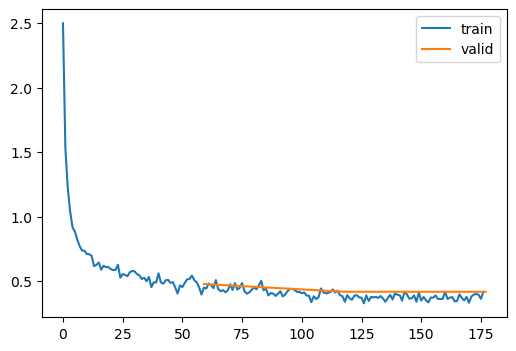

In [ ]:

learn.fit(3)

In [5]:
' '.join(filter(lambda x: x[0].isupper() and x[1].islower(), dir(lr_scheduler)))

'ChainedScheduler ConstantLR CosineAnnealingLR CosineAnnealingWarmRestarts Counter CyclicLR ExponentialLR LambdaLR LinearLR MultiStepLR MultiplicativeLR OneCycleLR Optimizer PolynomialLR ReduceLROnPlateau SequentialLR StepLR'

In [6]:
' '.join([o for o in dir(lr_scheduler) if o[0].isupper() and o[1].islower()])

'ChainedScheduler ConstantLR CosineAnnealingLR CosineAnnealingWarmRestarts Counter CyclicLR ExponentialLR LambdaLR LinearLR MultiStepLR MultiplicativeLR OneCycleLR Optimizer PolynomialLR ReduceLROnPlateau SequentialLR StepLR'

In [65]:
learn = TrainLearner(get_model(), dls, F.cross_entropy, 6e-3,cbs=[DeviceCB(), SingleBatchCB()])
learn.fit(1)

In [13]:
opt = learn.opt
' '.join(o for o in dir(opt) if o[0] != '_')

'add_param_group defaults load_state_dict param_groups profile_hook_step register_step_post_hook register_step_pre_hook state state_dict step zero_grad'

In [14]:
opt

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.006
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [22]:
for p in learn.model.parameters(): print(p.type)

<built-in method type of Parameter object at 0x7f3b4878c180>
<built-in method type of Parameter object at 0x7f3b4878cbd0>
<built-in method type of Parameter object at 0x7f3b487a37e0>
<built-in method type of Parameter object at 0x7f3b487a35b0>
<built-in method type of Parameter object at 0x7f3b4878c220>
<built-in method type of Parameter object at 0x7f3b4878c770>
<built-in method type of Parameter object at 0x7f3b7fe922f0>
<built-in method type of Parameter object at 0x7f3b7fe92110>
<built-in method type of Parameter object at 0x7f3b7fe920c0>
<built-in method type of Parameter object at 0x7f3b7fe91fd0>


In [21]:
param = next(iter(learn.model.parameters()))
st = opt.state[param]
st

{'momentum_buffer': None}

In [23]:
len(opt.param_groups)

1

In [28]:
pg = opt.param_groups[0]
list(pg)

['params',
 'lr',
 'momentum',
 'dampening',
 'weight_decay',
 'nesterov',
 'maximize',
 'foreach',
 'differentiable']

In [66]:
sched = lr_scheduler.CosineAnnealingLR(opt,100)

In [67]:
sched.base_lrs, sched.get_last_lr()

([0.006], [0.00014683045111453906])

In [70]:
def sched_lrs(sched, steps):
    lrs = [sched.get_last_lr()]
    for i in range(steps):
        sched.optimizer.step()
        sched.step()
        lrs.append(sched.get_last_lr())
    plt.plot(lrs)

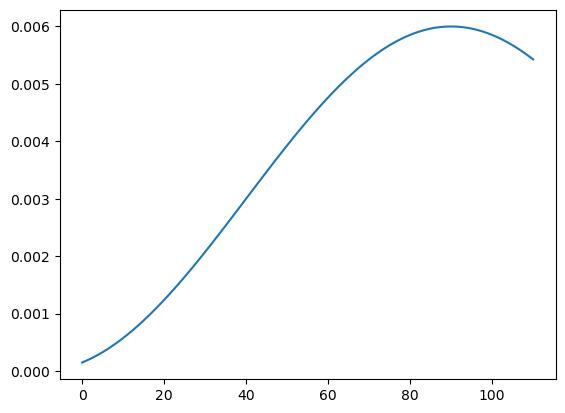

In [71]:
sched_lrs(sched, 110)

In [79]:
d={'a':1,'b':2}

In [80]:
recs = {k:[] for k in d}

In [81]:
recs

{'a': [], 'b': []}